In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import IsolationForest
import shap
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
# Loading the dataset into a pandas data frame
credit_card_data = pd.read_csv('creditcard.csv')

In [4]:
# Display the shape and first 5 rows of the dataframe
print(credit_card_data.shape)
print(credit_card_data.head())

(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

In [5]:
# Check for duplicate records
duplicate_rows = credit_card_data.duplicated().sum()
print('Number of duplicate records:', duplicate_rows)

Number of duplicate records: 1081


In [6]:
# Remove duplicate records
credit_card_data = credit_card_data.drop_duplicates()

In [7]:
# Check the number of missing values in each column
print(credit_card_data.isnull().sum())


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [8]:
# Display the distribution of legitimate transactions and fraudulent transactions
print(credit_card_data['Class'].value_counts())

0    283253
1       473
Name: Class, dtype: int64


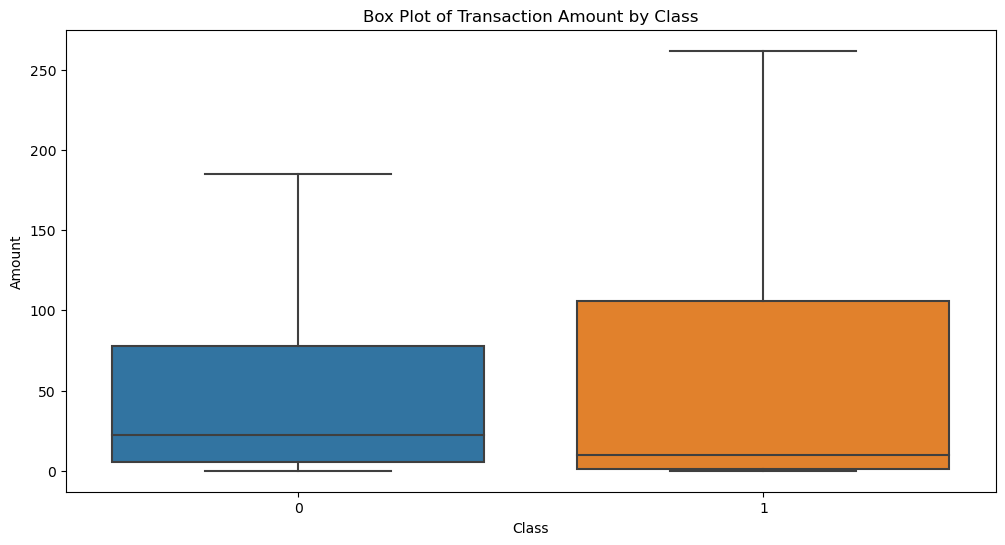

In [9]:
# Box plots for 'Amount' and 'Time' by Class
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Amount', data=credit_card_data, showfliers=False)
plt.title('Box Plot of Transaction Amount by Class')
plt.show()

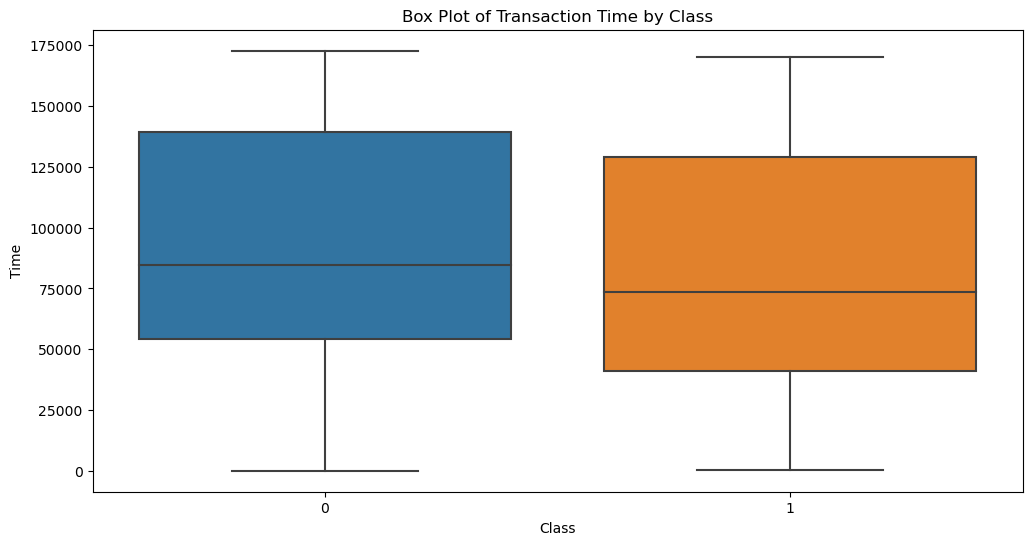

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Time', data=credit_card_data, showfliers=False)
plt.title('Box Plot of Transaction Time by Class')
plt.show()

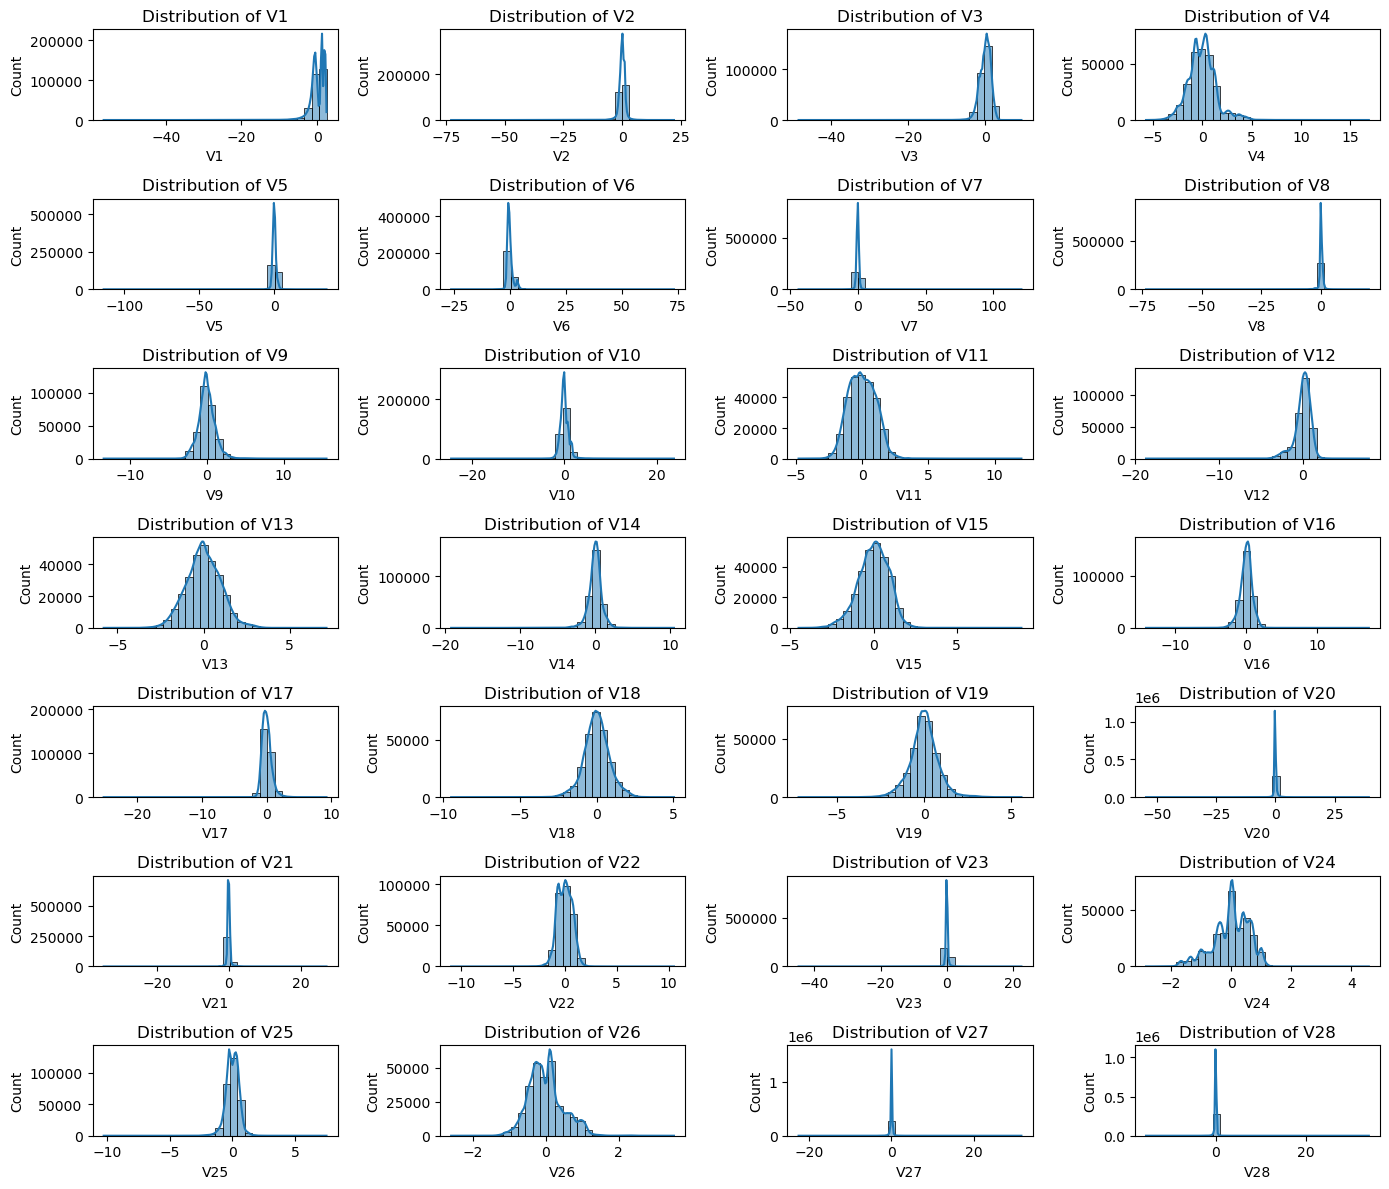

In [11]:
# Explore feature distributions
plt.figure(figsize=(14, 12))
for i in range(1, 29):  # Assuming V1 to V28 are the feature columns
    plt.subplot(7, 4, i)
    sns.histplot(credit_card_data[f'V{i}'], bins=30, kde=True)
    plt.title(f'Distribution of V{i}')
plt.tight_layout()
plt.show()

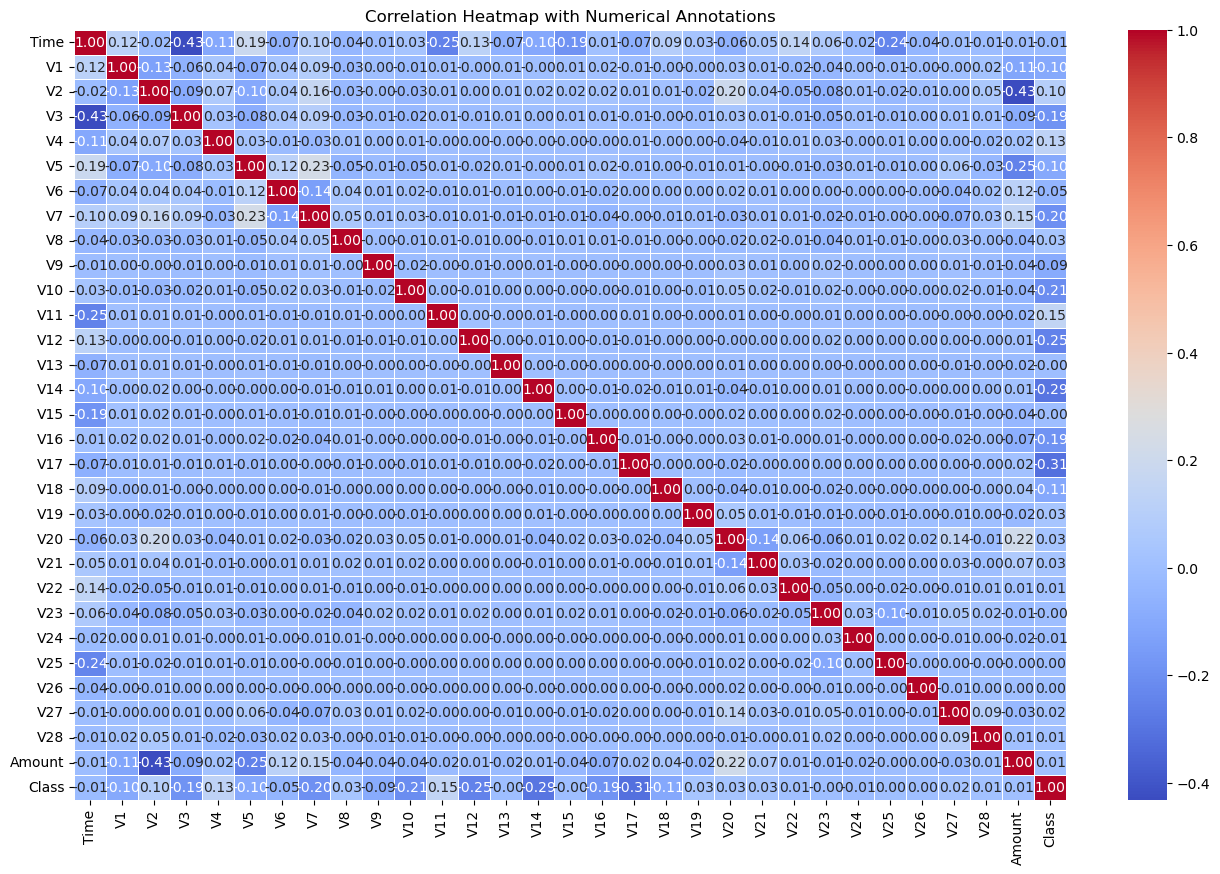

In [13]:
# Correlation Heatmap
plt.figure(figsize=(16, 10))
correlation_matrix = credit_card_data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap with Numerical Annotations')
plt.show()

In [14]:
# Data Cleaning and Preprocessing

# Handling outliers using Isolation Forest for 'Amount' and 'Time'
outlier_detector = IsolationForest(contamination=0.01, random_state=1)
credit_card_data['Outlier'] = outlier_detector.fit_predict(credit_card_data[['Amount', 'Time']])
credit_card_data = credit_card_data[credit_card_data['Outlier'] == 1].drop(columns='Outlier')

X does not have valid feature names, but IsolationForest was fitted with feature names


In [15]:
# Scaling 'Amount' using StandardScaler
scaler = StandardScaler()
credit_card_data['Amount'] = scaler.fit_transform(credit_card_data[['Amount']])


In [16]:
# Under-sampling
Legit = credit_card_data[credit_card_data['Class'] == 0]
fraud = credit_card_data[credit_card_data['Class'] == 1]
Legit_sample = Legit.sample(n=492)
new_dataset = pd.concat([Legit_sample, fraud], axis=0)

In [17]:
# Split the data into features and targets
X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']

In [18]:
# Split the data into Training data and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [19]:
# Model Selection

# Model training: Logistic Regression
logistic_model = LogisticRegression(random_state=2, max_iter=10000, solver='lbfgs')  # Increase max_iter and specify solver


In [20]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(random_state=2, max_iter=10000, solver='lbfgs'), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000, random_state=2),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [21]:
# Get the best hyperparameter
best_C = grid_search.best_params_['C']

In [22]:
# Model Training with the best hyperparameter
logistic_model = LogisticRegression(C=best_C, random_state=2, max_iter=10000, solver='lbfgs')  # Increase max_iter and specify solver
logistic_model.fit(X_train, Y_train)

LogisticRegression(C=10, max_iter=10000, random_state=2)

In [23]:
# Cross-Validation
cross_val_scores = cross_val_score(logistic_model, X_train, Y_train, cv=5, scoring='accuracy')
print('Cross-Validation Scores:', cross_val_scores)


Cross-Validation Scores: [0.95364238 0.89403974 0.94039735 0.9205298  0.94039735]


In [24]:
# Model Evaluation

# Accuracy score on training data for Logistic Regression
X_train_prediction_logistic = logistic_model.predict(X_train)
training_data_accuracy_logistic = accuracy_score(X_train_prediction_logistic, Y_train)
print('Logistic Regression Training data accuracy:', training_data_accuracy_logistic)


Logistic Regression Training data accuracy: 0.919205298013245


In [25]:
# Accuracy score on test data for Logistic Regression
X_test_prediction_logistic = logistic_model.predict(X_test)
test_data_accuracy_logistic = accuracy_score(X_test_prediction_logistic, Y_test)
print('Logistic Regression Test data accuracy:', test_data_accuracy_logistic)

Logistic Regression Test data accuracy: 0.9682539682539683


In [26]:
# Additional Model Evaluation Metrics for Logistic Regression
logistic_train_auc = roc_auc_score(Y_train, logistic_model.predict_proba(X_train)[:, 1])
logistic_test_auc = roc_auc_score(Y_test, logistic_model.predict_proba(X_test)[:, 1])

print('Logistic Regression Train AUC:', logistic_train_auc)
print('Logistic Regression Test AUC:', logistic_test_auc)

Logistic Regression Train AUC: 0.9585424486525242
Logistic Regression Test AUC: 0.9813692480359146


In [27]:
# Model Comparison (Random Forest as an alternative)
rf_model = RandomForestClassifier(random_state=2)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=2)

In [28]:
# Additional Model Evaluation Metrics for Random Forest
rf_train_auc = roc_auc_score(Y_train, rf_model.predict_proba(X_train)[:, 1])
rf_test_auc = roc_auc_score(Y_test, rf_model.predict_proba(X_test)[:, 1])
print('Random Forest Train AUC:', rf_train_auc)
print('Random Forest Test AUC:', rf_test_auc)

Random Forest Train AUC: 1.0
Random Forest Test AUC: 0.9971380471380471


In [27]:
# Classification report and confusion matrix for Logistic Regression
print('\nClassification Report (Logistic Regression):\n', classification_report(Y_test, X_test_prediction_logistic))
print('\nConfusion Matrix (Logistic Regression):\n', confusion_matrix(Y_test, X_test_prediction_logistic))



Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.93      0.96      0.95        99
           1       0.96      0.92      0.94        93

    accuracy                           0.94       192
   macro avg       0.94      0.94      0.94       192
weighted avg       0.94      0.94      0.94       192


Confusion Matrix (Logistic Regression):
 [[95  4]
 [ 7 86]]


In [29]:
# Classification report and confusion matrix for Random Forest
print('\nClassification Report (Random Forest):\n', classification_report(Y_test, rf_model.predict(X_test)))
print('\nConfusion Matrix (Random Forest):\n', confusion_matrix(Y_test, rf_model.predict(X_test)))


Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97        99
           1       0.99      0.94      0.97        90

    accuracy                           0.97       189
   macro avg       0.97      0.97      0.97       189
weighted avg       0.97      0.97      0.97       189


Confusion Matrix (Random Forest):
 [[98  1]
 [ 5 85]]


In [30]:
# Model Interpretability

# Logistic Regression coefficients
feature_names = X.columns
coefficients = logistic_model.coef_[0]
feature_importance_logistic = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_logistic = feature_importance_logistic.sort_values(by='Coefficient', ascending=False)
print('\nLogistic Regression Coefficients:\n', feature_importance_logistic)



Logistic Regression Coefficients:
    Feature  Coefficient
4       V4     0.501336
11     V11     0.409186
2       V2     0.390021
8       V8     0.115932
19     V19     0.077709
20     V20     0.044926
21     V21     0.044799
27     V27     0.021512
29  Amount     0.016601
22     V22     0.014831
28     V28     0.013091
25     V25     0.004711
26     V26     0.003162
0     Time    -0.000021
15     V15    -0.007286
23     V23    -0.007490
24     V24    -0.011826
13     V13    -0.012183
6       V6    -0.169447
18     V18    -0.246421
9       V9    -0.289611
5       V5    -0.327710
16     V16    -0.446486
1       V1    -0.492651
7       V7    -0.582358
10     V10    -0.607652
12     V12    -0.687016
17     V17    -0.710398
3       V3    -0.764218
14     V14    -0.767425


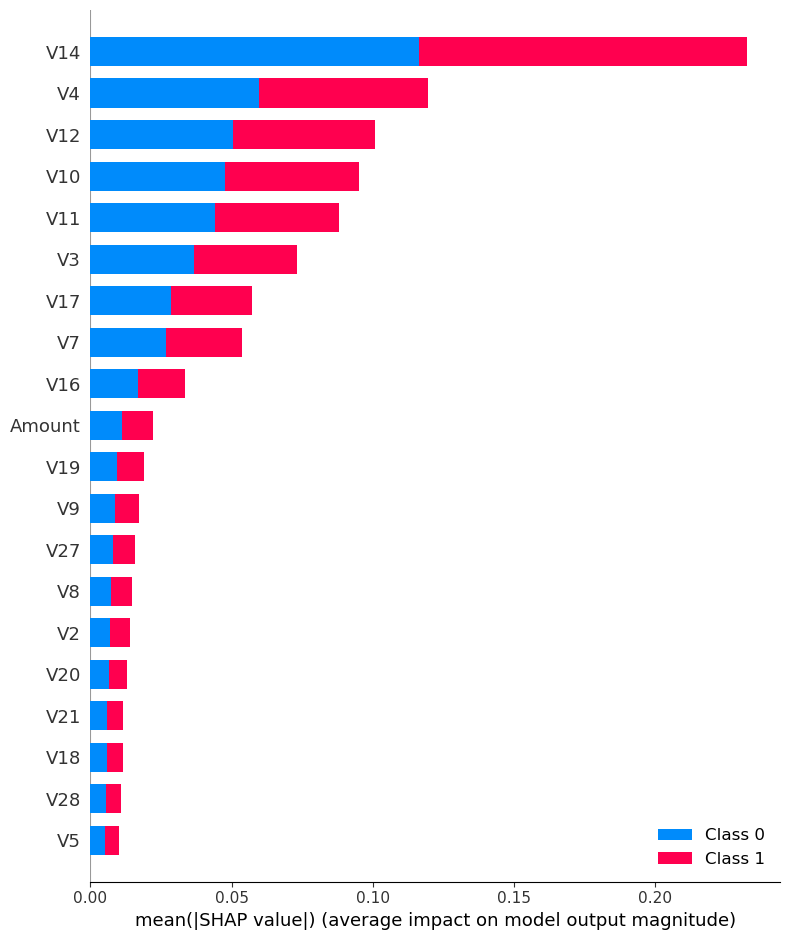

In [31]:
# SHAP values for Random Forest
shap_values_rf = shap.TreeExplainer(rf_model).shap_values(X_train)
shap.summary_plot(shap_values_rf, X_train, plot_type='bar')

In [32]:
# Save models to pickle files
import pickle

# Save Logistic Regression model to a file
with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(logistic_model, file)

# Save Random Forest model to a file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)